# **Multinomial Logistic Regression with scikit-learn**

Author: Nikos Papakostas   
Created: November 2024  
GitHub: https://github.com/papaknik  
LinkedIn: https://www.linkedin.com/in/nikos-papakostas/

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy             
import sklearn
import imblearn
import joblib
import openmeteo_requests
import requests_cache
import retry_requests
import json
import skopt
import watermark
%load_ext watermark

In [2]:
%watermark

Last updated: 2025-02-17T14:00:09.313266+02:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 8.30.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit



In [3]:
%watermark -v

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 8.30.0



In [4]:
%watermark --iversions

retry_requests    : 2.0.0
sklearn           : 1.6.1
skopt             : 0.10.2
requests_cache    : 1.2.1
pandas            : 2.2.3
seaborn           : 0.13.2
watermark         : 2.5.0
numpy             : 2.2.2
json              : 2.0.9
IPython           : 8.30.0
matplotlib        : 3.10.0
joblib            : 1.4.2
openmeteo_requests: 1.3.0
imblearn          : 0.0
scipy             : 1.15.1



## **Introduction**

This practice project utilizes data extracted from the Open-Meteo Historical Weather API to construct a Multinomial Classification problem.   
The dataset contains numerical weather attributes as independent variables, and we aim to predict a categorical target variable named 'weather_event', which can take the following values:

    0: No precipitation
    1: Rain event
    2: Snowfall event  
    
The major challenge of this project is the complete lack of Domain Knowledge which is a key asset in any machine learning project.  
With limited time for subject research, I followed two simple steps:
1. Research similar machine learning tasks: I searched online for related ML projects to identify commonly used weather variables that could serve as predictors.
2. Logical reasoning: Before attempting to predict an event you first must be able to describe it. I considered how weather is usually described in forecasts, focusing on attributes like temperature, wind, humidity, and precipitation likelihood.

The dataset includes historical weather data from 2019 to 2023 for the center of Athens, Greece, and will serve as a practice set for multinomial classification. Our goal is to predict whether there will be no precipitation, rain, or snow at the specified location, utilizing Logistic Regression algorithm.   
In subsequent notebooks, we will explore different algorithms to tackle this problem.

**<u> Important note</u>**   
This project does not aim to replicate professional weather forecasting, where advanced numerical simulations and physical models are applied.   
These models rely on complex simulations of atmospheric processes and can predict future values for key weather variables over time, while in this project our predictive modeling will be based purely on historical data.

### Dataset Description

- temperature_2m: Represents the air temperature measured at a height of 2 meters above the ground. This is a standard height for temperature observations in weather forecasting.

- relative_humidity_2m: Measures the percentage of moisture in the air relative to the maximum amount of moisture the air can hold at the same temperature.

- dew_point_2m: Indicates the temperature at which air becomes saturated with moisture and condensation begins, leading to the formation of dew, fog, or clouds.

- rain: This variable measures the precipitation from rain, typically expressed in millimeters (mm). It represents the amount of rainfall over a certain period (e.g., hourly). Higher values indicate heavier rainfall.

- snowfall: This variable records the amount of precipitation in the form of snow, also generally measured in millimeters (mm). Like rain, it provides insight into the accumulation of snow over time.

- surface_pressure: Refers to the atmospheric pressure exerted at the Earth's surface, typically measured in hectopascals (hPa). It is crucial for determining weather conditions like high and low-pressure systems.

- cloud_cover_low & cloud_cover_mid: Represents the percentage of the sky covered by low-level and mid-level clouds. Low clouds form close to the ground, while mid clouds occur higher up in the atmosphere.

- evapotranspiration: Reflects the combined process of water evaporation from the surface and transpiration from plants. It is used to estimate water loss in ecosystems.

- vapour_pressure_deficit: Represents the difference between the amount of moisture in the air and how much moisture the air can hold when it is saturated. It’s often used to assess plant water stress.

- wind_speed_10m: Measures the wind velocity at a height of 10 meters above the surface, which is the standard height for wind observations.

- wind_gusts_10m: Indicates the sudden, short-term increases in wind speed at 10 meters above the surface, which can impact weather severity.

- soil_temp_0_to_7cm: Measures the temperature of the soil in the top 7 cm layer, which is important for agriculture and assessing soil conditions.

- soil_moist_0_to_7cm: Reflects the water content in the top 7 cm of soil, important for understanding drought conditions and plant water availability.

- direct_radiation: Measures the amount of solar radiation received by the Earth’s surface directly from the sun, without scattering by clouds or the atmosphere. This is important for energy balance calculations.

Detailed information about the selected variables, as well as all available options, can be found **[here](https://open-meteo.com/en/docs/historical-forecast-api#start_date=2024-09-30).**

### Scraping with Open-Meteo API

Scraping data using the Open-Meteo Historical Forecast API is a simple process that can be completed in just a few steps.
First, ensure that the required Python `openmeteo_requests`, `requests_cache` and `retry_requests` modules are installed in your environment.   
If not, try running the following commands:   
`pip install openmeteo_requests`   
`pip install requests_cache` and   
`pip install retry_requests`   

Once the modules are installed, follow these steps:

- <u>Navigate to the Open-Meteo Historical Weather API documentation, **[here](https://open-meteo.com/en/docs/historical-forecast-api#start_date=2024-09-30)</u>**
- Select the coordinates of the desired location (e.g., a city or a specific latitude and longitude).
- Choose the time interval by setting the Start Date and End Date.
- Pick the parameters (e.g., temperature, precipitation, wind speed) that you are interested in.

The API will generate a Python code snippet for you. Copy and paste this snippet into your notebook or script, and you are all set to start scraping data!

**You can skip the following step and use directly the csv file that can be found in the `/data` folder of the repository in [GitHub](https://github.com/papaknik/Multinomial-Logistic-Regression-with-scikit-learn).**

In [21]:
import openmeteo_requests
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 37.9838,
	"longitude": 23.7278,
	"start_date": "2019-01-01",
	"end_date": "2023-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "rain", "snowfall", 
               "surface_pressure", "cloud_cover_low", "cloud_cover_mid", "et0_fao_evapotranspiration", 
               "vapour_pressure_deficit", "wind_speed_10m", "wind_gusts_10m", "soil_temperature_0_to_7cm", 
               "soil_moisture_0_to_7cm", "direct_radiation"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(5).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(6).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(7).ValuesAsNumpy()
hourly_et0_fao_evapotranspiration = hourly.Variables(8).ValuesAsNumpy()
hourly_vapour_pressure_deficit = hourly.Variables(9).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(10).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(11).ValuesAsNumpy()
hourly_soil_temperature_0_to_7cm = hourly.Variables(12).ValuesAsNumpy()
hourly_soil_moisture_0_to_7cm = hourly.Variables(13).ValuesAsNumpy()
hourly_direct_radiation = hourly.Variables(14).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["evapotranspiration"] = hourly_et0_fao_evapotranspiration
hourly_data["vapour_pressure_deficit"] = hourly_vapour_pressure_deficit
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["soil_temp_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
hourly_data["soil_moist_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
hourly_data["direct_radiation"] = hourly_direct_radiation

df = pd.DataFrame(data = hourly_data)
df.info()

Coordinates 37.996482849121094°N 23.70967674255371°E
Elevation 92.0 m asl
Timezone b'Europe/Athens' b'GMT+2'
Timezone difference to GMT+0 7200 s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   date                     43824 non-null  datetime64[ns, UTC]
 1   temperature_2m           43824 non-null  float32            
 2   relative_humidity_2m     43824 non-null  float32            
 3   dew_point_2m             43824 non-null  float32            
 4   rain                     43824 non-null  float32            
 5   snowfall                 43824 non-null  float32            
 6   surface_pressure         43824 non-null  float32            
 7   cloud_cover_low          43824 non-null  float32            
 8   cloud_cover_mid          43824 non-null  float32            
 9   evapotranspirat

### Creating the multiclass target variable

The first step is to create the target variable 'weather_event' for our multi-class classification problem.   
We create a new column called 'weather_event' with the following rules:

    0: When both the 'rain' and 'snowfall' variables are 0 (indicating no precipitation).
    1: When the 'rain' variable is greater than 0 and the 'snowfall' variable is 0 (indicating a rain event).
    2: When the 'snowfall' variable is greater than 0 and the 'rain' variable is 0 (indicating a snowfall event).

Occasionally, there are some rare instances over the 5-year period where both rain and snowfall occurred within the same hour. In these cases, we assign to 'weather_event', the value based on which variable has the higher precipitation (rain or snowfall), ensuring that the most significant weather event is captured.

In [22]:
# Define the conditions
conditions = [
    (df['rain'] > 0) & (df['snowfall'] > 0),   # Both rain and snowfall
    (df['rain'] > 0) & (df['snowfall'] == 0),  # Only rain
    (df['snowfall'] > 0) & (df['rain'] == 0)   # Only snowfall
]

# Define the values for each condition
values = [
    np.where(df['rain'] > df['snowfall'], 1, 2),  # Choose rain if higher, otherwise snowfall
    1,  # Only rain
    2   # Only snowfall
]

# Use np.select to create the 'weather_event' column
df['weather_event'] = np.select(conditions, values, default=0)  # Default is 0 for no precipitation

Removing the columns 'rain' and 'snowfall' since they are no longer needed after the creation of the target variable

In [23]:
df = df.drop(columns=['rain', 'snowfall'])

### Adding a time related variable in the dataset

Everyone knows from life experience that weather is closely tied to seasons, meaning that the likelihood of a 'snowfall' event is much higher during winter months, or that the likelihood of 'rain' is expected to be lower during the months of July and August *(at least up to most recent years...)*.   
Considering this, the addition of the month as a numerical variable (ranging from 1 to 12), can be a valuable addition to the dataset, and we expect it to have significant predictive power in the models we build.

In [24]:
df['month'] = df['date'].dt.month

But when plotting the month, we see something strange on the plot. While the months from 1 (January) to 12 (December) escalate sequentially by a step of 1, when reaching 12, the plot jumps back to 1 and repeats the same pattern.  This means that encoding the month variable by a strict integer with a step of 1 exhibits a discontinuity when reaching December in every year of the dataframe. So, in the months of December and January while they should have a distance of 1 as all other consecutive months exhibit, their difference with the simple integer encoding is 11 (12-1)!
This is well known for all features that exhibit a cyclical behavior by nature and must be handled before modeling, in order to help the model interpret the influence of the 'month' variable on the result (predicting the target variable) more efficiently.

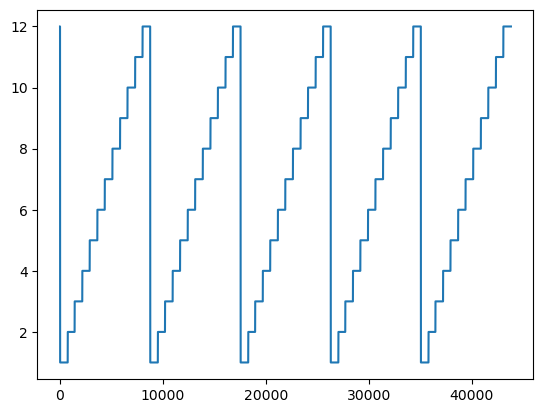

In [25]:
ax = df['month'].plot()

We can encode the `month` variable so as to capture its cyclical behavior and eliminate the discontinuity observed between months of December and January.   
You can find more information on encoding cyclical features for ML modeling purposes in the link below:   
https://feature-engine.trainindata.com/en/1.7.x/user_guide/creation/CyclicalFeatures.html

In [26]:
# Applying sin and cosine transformation on the  variable
df['month_sin'] = np.round(np.sin(2 * np.pi * df['month'] / 12), decimals=3)
df['month_cos'] = np.round(np.cos(2 * np.pi * df['month'] / 12), decimals=3)

We can plot the sin and cosine transformations of the variable `month` and see that the discontinuity has been eliminated. The values on the y-axis for the transformed `month` variable in January (1) and December (12) are much closer than in the case of the absolute integer encoding.

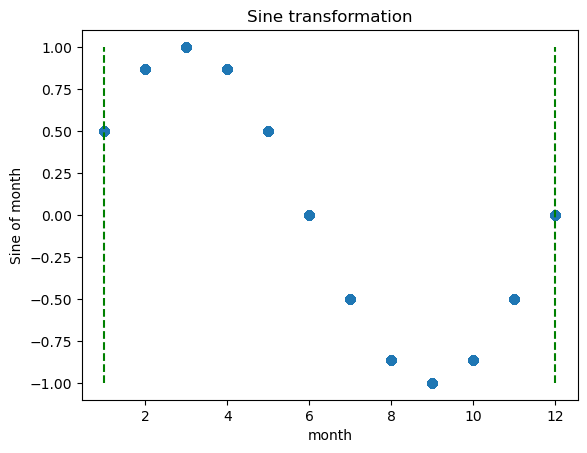

In [27]:
plot = plt.scatter(df["month"], df["month_sin"])
vline1 = plt.vlines(x=1, ymin=-1, ymax=1, color='g', linestyles='dashed')
vline2 = plt.vlines(x=12, ymin=-1, ymax=1, color='g', linestyles='dashed')
# Axis labels
ylabel = plt.ylabel('Sine of month')
xlabel = plt.xlabel('month')
title = plt.title('Sine transformation')

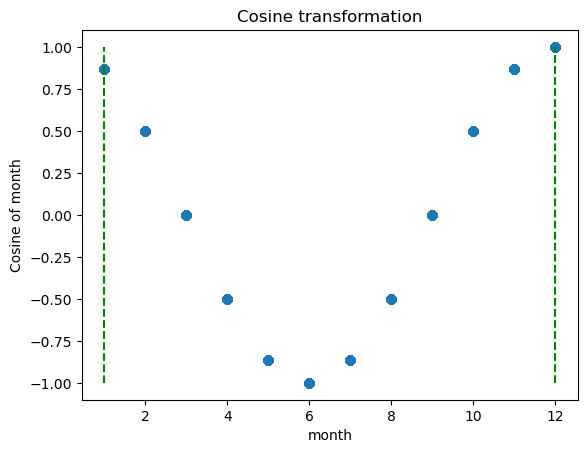

In [28]:
plot = plt.scatter(df["month"], df["month_cos"])
vline1 = plt.vlines(x=1, ymin=-1, ymax=1, color='g', linestyles='dashed')
vline2 = plt.vlines(x=12, ymin=-1, ymax=1, color='g', linestyles='dashed')
# Axis labels
ylabel = plt.ylabel('Cosine of month')
xlabel = plt.xlabel('month')
title = plt.title('Cosine transformation')

We can also scatter plot the 2 transformed variables and observe that the cyclical nature of the month variable has been successfully captured.

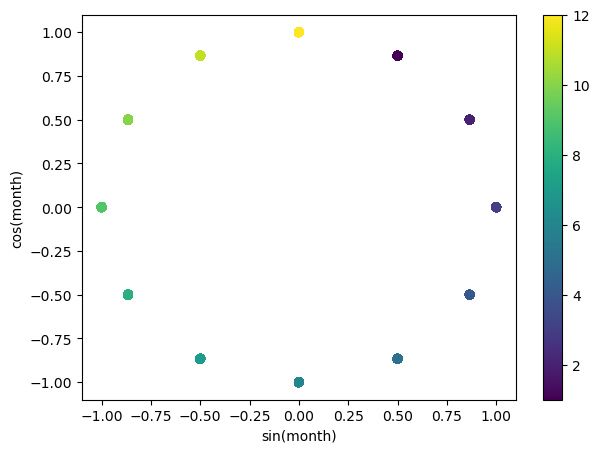

In [29]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(df['month_sin'], df['month_cos'], c=df["month"])
axis = ax.set(
    xlabel="sin(month)",
    ylabel="cos(month)",
)
colorbar = fig.colorbar(sp)

In the above plot we observe how the month of December (value 12-deep yellow color) neighbors with January (value 1-dark blue color), eliminating the discontinuity of the original `month` variable.

Since the `month` variable is no longer needed we drop it from the dataframe

In [30]:
# Drop the original month column since it is no longer needed
df = df.drop('month', axis=1)

### Creating Lagged Variables for Predictive Modeling

Predicting current weather using present data isn’t true forecasting.   
To make this project more realistic and challenging, we will introduce lagged variables.   
Specifically, to predict whether it will rain, snow, or not at a given `time point t`, we will use weather parameters from one hour earlier (`time point t-1`). This approach enables us to predict future weather conditions based on past observations, simulating the use of historical data.   
The addition of lagged variables makes the project more challenging and adds a touch of realism, while at the same time we can still practice with ML classification algorithms 

Feel free to experiment and alter the data to your liking.   
Instead of using the previous hour's weather attributes, you can use the values from the past 3 hours, or even compile a moving average value, for example an average of the past 3 hours where you average the values of each predictor for the time points t-3, t-2 and t-1, in order to predict the 'weather_event' attribute at time point t.

In [31]:
# List of columns for which to create lag variables
lag_columns = ["temperature_2m", 
    "relative_humidity_2m", 
    "dew_point_2m", 
    "surface_pressure", 
    "cloud_cover_low", 
    "cloud_cover_mid", 
    "evapotranspiration", 
    "vapour_pressure_deficit", 
    "wind_speed_10m", 
    "wind_gusts_10m", 
    "soil_temp_0_to_7cm", 
    "soil_moist_0_to_7cm", 
    "direct_radiation",
]

# Create a new DataFrame to store the lagged features
lagged_1h_df = df.copy()  # Copy the original DataFrame to modify it

# Create 1-hour lagged features
for col in lag_columns:
    lagged_1h_df[f'{col}_lag_1h'] = df[col].shift(1)  # Shift by 1 step (1 hour back in the data)

# Drop rows with NaN values (if any), that result from the lagging process
lagged_1h_df = lagged_1h_df.dropna(subset=[f'{col}_lag_1h' for col in lag_columns])

# Drop the current-time columns to keep only the lagged versions
lagged_1h_df = lagged_1h_df.drop(columns=lag_columns)

A common practice in ML is to place the target/response variable as the final column in the dataframe, clearly separated from the predictor variables.

In [32]:
# Remove (pop) the 'weather_event' column from the DataFrame.
weather_event = lagged_1h_df.pop('weather_event')

# Reassign it as the last column.
lagged_1h_df['weather_event'] = weather_event

# Verify the new order:
lagged_1h_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43823 entries, 1 to 43823
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   date                            43823 non-null  datetime64[ns, UTC]
 1   month_sin                       43823 non-null  float64            
 2   month_cos                       43823 non-null  float64            
 3   temperature_2m_lag_1h           43823 non-null  float32            
 4   relative_humidity_2m_lag_1h     43823 non-null  float32            
 5   dew_point_2m_lag_1h             43823 non-null  float32            
 6   surface_pressure_lag_1h         43823 non-null  float32            
 7   cloud_cover_low_lag_1h          43823 non-null  float32            
 8   cloud_cover_mid_lag_1h          43823 non-null  float32            
 9   evapotranspiration_lag_1h       43823 non-null  float32            
 10  vapour_pressure

**Save the dataframe to a `csv` file for later use**

In [33]:
athens_weather_df_2019_2023 = lagged_1h_df.to_csv('../data/athens_weather_df_2019_2023.csv', index=False)